# Avaliação da Versão Otimizada do Chatbot LAI

Este notebook implementa as métricas de avaliação para a versão otimizada do chatbot LAI (TF-IDF + sklearn).


In [20]:
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score


## 1. Carregar Artigos


In [21]:
def carregar_artigos(caminho_txt="../../data/processed/sentencas.txt"):
    artigos = []
    with open(caminho_txt, "r", encoding="utf-8") as f:
        bloco = ""
        artigo_id = ""
        for linha in f:
            linha = linha.strip()
            if linha.startswith("[ARTIGO_"):
                if artigo_id and bloco:
                    artigos.append({"id": artigo_id, "texto": bloco.strip()})
                artigo_id = linha.strip("[]")
                bloco = ""
            else:
                bloco += " " + linha
        if artigo_id and bloco:
            artigos.append({"id": artigo_id, "texto": bloco.strip()})
    return artigos

# Carregar artigos
print("[*] Carregando artigos...")
artigos = carregar_artigos("../../data/processed/sentencas.txt")
print(f"[*] {len(artigos)} artigos carregados.")


[*] Carregando artigos...
[*] 50 artigos carregados.


In [22]:
# Função para carregar entidades nomeadas
def carregar_entidades(caminho_entidades="../../data/processed/entidades_filtradas.txt"):
    print(f"[*] Carregando entidades de {caminho_entidades}...")
    entidades = []
    with open(caminho_entidades, "r", encoding="utf-8") as f:
        next(f)  # Pular cabeçalho
        for linha in f:
            if linha.strip():
                partes = linha.strip().split("\t")
                if len(partes) >= 2:
                    entidade, label = partes[0], partes[1]
                    entidades.append({"texto": entidade, "tipo": label})
    print(f"[*] {len(entidades)} entidades carregadas.")
    return entidades

# Função para carregar tokens filtrados
def carregar_tokens(caminho_tokens="../../data/processed/tokens_filtrados.txt"):
    print(f"[*] Carregando tokens de {caminho_tokens}...")
    tokens = []
    with open(caminho_tokens, "r", encoding="utf-8") as f:
        next(f)  # Pular cabeçalho
        for linha in f:
            if linha.strip():
                partes = linha.strip().split("\t")
                if len(partes) >= 3:
                    texto, lemma, pos = partes[0], partes[1], partes[2]
                    tokens.append({"texto": texto, "lemma": lemma, "pos": pos})
    print(f"[*] {len(tokens)} tokens carregados.")
    return tokens

# Carregar entidades e tokens
entidades_filtradas = carregar_entidades("../../data/processed/entidades_filtradas.txt")
entidades_ner = carregar_entidades("../../data/processed/entidades_ner.txt")
tokens_filtrados = carregar_tokens("../../data/processed/tokens_filtrados.txt")

# Criar dicionários para acesso rápido
entidades_dict = {e["texto"].lower(): e["tipo"] for e in entidades_filtradas}
entidades_ner_dict = {e["texto"].lower(): e["tipo"] for e in entidades_ner}
tokens_importantes = {t["texto"].lower(): t["pos"] for t in tokens_filtrados if t["pos"] in ["NOUN", "VERB", "ADJ", "PROPN"]}


[*] Carregando entidades de ../../data/processed/entidades_filtradas.txt...
[*] 74 entidades carregadas.
[*] Carregando entidades de ../../data/processed/entidades_ner.txt...
[*] 375 entidades carregadas.
[*] Carregando tokens de ../../data/processed/tokens_filtrados.txt...
[*] 3731 tokens carregados.


In [23]:
def enriquecer_texto(texto, entidades_dict, entidades_ner_dict, tokens_importantes):
    """Enriquece o texto identificando entidades e tokens importantes"""
    import re
    from unidecode import unidecode
    
    # Normalização básica
    texto = texto.lower()
    texto = re.sub(r'art\.\s*\d+º?', '', texto)  # Remover referências a artigos
    texto = re.sub(r'§\s*\d+º?', '', texto)  # Remover parágrafos
    texto = re.sub(r'^\s*\d+\.\s*', '', texto)  # Remover numerações
    
    # Manter o texto original para busca de entidades
    texto_original = texto
    texto_enriquecido = texto
    
    # Adicionar marcadores para entidades filtradas (com repetição para dar mais peso)
    for entidade, tipo in entidades_dict.items():
        entidade_norm = entidade.lower()
        if entidade_norm in texto_original.lower():
            # Repetir 3x para dar mais peso
            texto_enriquecido += f" [ENTIDADE:{entidade}:{tipo}] [ENTIDADE:{entidade}:{tipo}] [ENTIDADE:{entidade}:{tipo}]"
    
    # Adicionar marcadores para entidades NER (com repetição para dar mais peso)
    for entidade, tipo in entidades_ner_dict.items():
        entidade_norm = entidade.lower()
        if entidade_norm in texto_original.lower() and len(entidade) > 3:  # Filtrar entidades muito curtas
            # Repetir 2x para dar mais peso
            texto_enriquecido += f" [NER:{entidade}:{tipo}] [NER:{entidade}:{tipo}]"
    
    # Adicionar tokens importantes com mais peso para substantivos e verbos
    palavras = texto_original.lower().split()
    tokens_encontrados = [token for token in palavras if token in tokens_importantes]
    for token in tokens_encontrados:
        pos = tokens_importantes[token]
        # Dar peso extra para substantivos e verbos
        if pos in ["NOUN", "PROPN"]:
            texto_enriquecido += f" [TOKEN:{token}:{pos}] [TOKEN:{token}:{pos}] [TOKEN:{token}:{pos}]"
        elif pos == "VERB":
            texto_enriquecido += f" [TOKEN:{token}:{pos}] [TOKEN:{token}:{pos}]"
        else:
            texto_enriquecido += f" [TOKEN:{token}:{pos}]"
    
    return texto_enriquecido

# Enriquecer artigos com entidades e tokens
print("[*] Enriquecendo artigos com entidades e tokens...")
for artigo in tqdm(artigos):
    artigo["texto_enriquecido"] = enriquecer_texto(
        artigo["texto"], 
        entidades_dict, 
        entidades_ner_dict, 
        tokens_importantes
    )

# Exibir um exemplo de texto enriquecido
print("\n[*] Exemplo de texto enriquecido:")
print(f"Original: {artigos[0]['texto'][:150]}...")
print(f"Enriquecido: {artigos[0]['texto_enriquecido'][:150]}...")


[*] Enriquecendo artigos com entidades e tokens...


100%|██████████| 50/50 [00:00<00:00, 2296.19it/s]


[*] Exemplo de texto enriquecido:
Original: Art. 1o Esta Lei dispoe sobre os procedimentos a serem observados pela Uniao, Estados, Distrito Federal e Municipios, com o fim de garantir o acesso a...
Enriquecido: o esta lei dispoe sobre os procedimentos a serem observados pela uniao, estados, distrito federal e municipios, com o fim de garantir o acesso a infor...


## 2. Gerar Vetores TF-IDF (Versão Otimizada)


In [24]:
def gerar_tfidf(textos):
    print("[*] Gerando vetores TF-IDF...")
    start_time = time.time()
    
    # Configuração otimizada do TF-IDF
    vectorizer = TfidfVectorizer(
        ngram_range=(1, 3),   # Uni, bi e trigramas
        max_features=12000,   # Aumentado para capturar mais termos
        min_df=1,             # Permitir termos que aparecem pelo menos uma vez
        max_df=0.90,          # Aumentar limite para termos comuns
        use_idf=True,         # Usar IDF para dar mais peso a termos raros
        sublinear_tf=True,    # Aplicar escala sublinear ao TF (1+log(tf))
        norm='l2',            # Normalização L2 para comparação por cosseno
        analyzer='word',      # Analisar por palavras
        token_pattern=r'(?u)\b\w\w+\b'  # Padrão para tokens (2+ caracteres)
    )
    
    # Fit e transform
    tfidf_matrix = vectorizer.fit_transform(textos)
    
    # Dar mais peso a termos importantes (entidades, substantivos, verbos)
    # Isso é feito modificando o vocabulário do vectorizer após o fit
    try:
        # Obter vocabulário e idf
        vocab = vectorizer.vocabulary_
        idf = vectorizer.idf_
        
        # Termos importantes (exemplo)
        termos_importantes = ['informação', 'acesso', 'lei', 'direito', 'público', 
                             'sigilo', 'classificação', 'transparência', 'pedido', 
                             'prazo', 'recurso', 'órgão', 'autoridade', 'cidadão']
        
        # Aumentar o IDF dos termos importantes (se estiverem no vocabulário)
        for termo in termos_importantes:
            if termo in vocab:
                idx = vocab[termo]
                # Aumentar o IDF em 30% para dar mais peso
                idf[idx] *= 1.3
        
        print("[*] Pesos IDF ajustados para termos importantes.")
    except:
        print("[!] Não foi possível ajustar pesos IDF para termos importantes.")
    
    end_time = time.time()
    print(f"[*] Vetores TF-IDF gerados em {end_time - start_time:.2f} segundos.")
    print(f"[*] Dimensões da matriz: {tfidf_matrix.shape}")
    
    return tfidf_matrix, vectorizer

# Extrair textos enriquecidos em vez dos textos originais
textos = [a["texto_enriquecido"] for a in artigos]

# Gerar matriz TF-IDF
tfidf_matrix, vectorizer = gerar_tfidf(textos)


[*] Gerando vetores TF-IDF...
[*] Pesos IDF ajustados para termos importantes.
[*] Vetores TF-IDF gerados em 0.08 segundos.
[*] Dimensões da matriz: (50, 12000)


## 3. Conjunto de Perguntas para Avaliação


In [25]:
# Conjunto de perguntas de teste com artigos relevantes esperados
perguntas_teste = [
    {
        "pergunta": "O que é a Lei de Acesso à Informação?",
        "artigos_relevantes": ["ARTIGO_1", "ARTIGO_2", "PREAMBULO"]
    },
    {
        "pergunta": "Como solicitar informações públicas?",
        "artigos_relevantes": ["ARTIGO_10", "ARTIGO_11", "ARTIGO_12"]
    },
    {
        "pergunta": "Qual o prazo para resposta do pedido de informação?",
        "artigos_relevantes": ["ARTIGO_11", "ARTIGO_15", "ARTIGO_16"]
    },
    {
        "pergunta": "Quais informações podem ser negadas?",
        "artigos_relevantes": ["ARTIGO_21", "ARTIGO_22", "ARTIGO_23", "ARTIGO_24"]
    },
    {
        "pergunta": "Quem pode solicitar informações públicas?",
        "artigos_relevantes": ["ARTIGO_10", "ARTIGO_11"]
    },
    {
        "pergunta": "Quais são as informações classificadas como sigilosas?",
        "artigos_relevantes": ["ARTIGO_23", "ARTIGO_24", "ARTIGO_25"]
    },
    {
        "pergunta": "Quais são as penalidades para quem não cumprir a LAI?",
        "artigos_relevantes": ["ARTIGO_32", "ARTIGO_33", "ARTIGO_34"]
    },
    {
        "pergunta": "Como recorrer de uma negativa de acesso à informação?",
        "artigos_relevantes": ["ARTIGO_15", "ARTIGO_16", "ARTIGO_17"]
    },
    {
        "pergunta": "Quais são os prazos de sigilo das informações?",
        "artigos_relevantes": ["ARTIGO_24", "ARTIGO_27", "ARTIGO_28"]
    },
    {
        "pergunta": "Como a LAI protege informações pessoais?",
        "artigos_relevantes": ["ARTIGO_31", "ARTIGO_32"]
    },
    {
        "pergunta": "Quais são os princípios da Lei de Acesso à Informação?",
        "artigos_relevantes": ["ARTIGO_3", "ARTIGO_5", "ARTIGO_6"]
    },
    {
        "pergunta": "O que são informações sigilosas segundo a LAI?",
        "artigos_relevantes": ["ARTIGO_4", "ARTIGO_23", "ARTIGO_24"]
    },
    {
        "pergunta": "Como é feita a classificação de informações sigilosas?",
        "artigos_relevantes": ["ARTIGO_24", "ARTIGO_25", "ARTIGO_26", "ARTIGO_27"]
    },
    {
        "pergunta": "Quais são os direitos do cidadão garantidos pela LAI?",
        "artigos_relevantes": ["ARTIGO_7", "ARTIGO_8", "ARTIGO_9", "ARTIGO_10"]
    },
    {
        "pergunta": "Quais informações devem ser divulgadas proativamente pelos órgãos públicos?",
        "artigos_relevantes": ["ARTIGO_8", "ARTIGO_9"]
    },
    {
        "pergunta": "Como funciona o recurso em caso de negativa de acesso à informação?",
        "artigos_relevantes": ["ARTIGO_15", "ARTIGO_16", "ARTIGO_17", "ARTIGO_18", "ARTIGO_19"]
    },
    {
        "pergunta": "Quais são as responsabilidades dos órgãos públicos em relação à LAI?",
        "artigos_relevantes": ["ARTIGO_6", "ARTIGO_7", "ARTIGO_8", "ARTIGO_9"]
    },
    {
        "pergunta": "Como é tratada a informação pessoal pela LAI?",
        "artigos_relevantes": ["ARTIGO_4", "ARTIGO_31"]
    },
    {
        "pergunta": "Qual a diferença entre informação sigilosa e informação pessoal?",
        "artigos_relevantes": ["ARTIGO_4", "ARTIGO_23", "ARTIGO_31"]
    },
    {
        "pergunta": "Como solicitar a desclassificação de uma informação sigilosa?",
        "artigos_relevantes": ["ARTIGO_17", "ARTIGO_29", "ARTIGO_30"]
    }
]

print(f"[*] {len(perguntas_teste)} perguntas de teste carregadas.")


[*] 20 perguntas de teste carregadas.


## 4. Função de Busca com TF-IDF e Avaliação


In [26]:
def buscar_pergunta_tfidf(pergunta, vectorizer, tfidf_matrix, artigos, top_k=30, entidades_dict=None, entidades_ner_dict=None, tokens_importantes=None):
    """Busca os artigos mais relevantes para uma pergunta usando TF-IDF"""
    start_time = time.time()
    
    # Enriquecer a pergunta com entidades e tokens importantes
    if entidades_dict and entidades_ner_dict and tokens_importantes:
        pergunta_enriquecida = enriquecer_texto(pergunta, entidades_dict, entidades_ner_dict, tokens_importantes)
    else:
        pergunta_enriquecida = pergunta
    
    # Transformar a pergunta em vetor TF-IDF
    pergunta_vector = vectorizer.transform([pergunta_enriquecida])
    
    # Calcular similaridade de cosseno entre a pergunta e todos os artigos
    similaridades = cosine_similarity(pergunta_vector, tfidf_matrix).flatten()
    
    # Ordenar por similaridade e obter os índices dos top_k resultados (aumentado para depois refinar)
    indices_top = similaridades.argsort()[-top_k:][::-1]
    
    # Calcular tempo de resposta
    tempo_resposta = time.time() - start_time
    
    # Recuperar artigos e aplicar re-ranking com heurísticas adicionais
    resultados = []
    for i, idx in enumerate(indices_top):
        artigo = artigos[idx]
        texto_artigo = artigo["texto"].lower()
        
        # Calcular similaridade adicional baseada em tokens compartilhados
        pergunta_tokens = set(pergunta.lower().split())
        artigo_tokens = set(texto_artigo.split())
        tokens_comuns = len(pergunta_tokens.intersection(artigo_tokens))
        
        # Calcular bonus para entidades compartilhadas
        bonus_entidades = 0
        if entidades_dict:
            for entidade in entidades_dict:
                if entidade.lower() in pergunta.lower() and entidade.lower() in texto_artigo:
                    bonus_entidades += 0.15  # Bonus de 15% por entidade compartilhada
        
        # Aplicar penalidade para artigos muito longos ou muito curtos
        tamanho_artigo = len(texto_artigo.split())
        fator_tamanho = 1.0
        if tamanho_artigo < 20:  # Artigos muito curtos
            fator_tamanho = 0.8
        elif tamanho_artigo > 500:  # Artigos muito longos
            fator_tamanho = 0.9
        
        # Calcular score combinado: similaridade TF-IDF + heurísticas
        score_base = float(similaridades[idx])
        score_combinado = score_base * (1 + bonus_entidades + tokens_comuns * 0.02) * fator_tamanho
        
        resultados.append({
            "rank": i + 1,
            "id": artigo["id"],
            "texto": artigo["texto"],
            "similaridade": score_combinado,
            "similaridade_original": score_base
        })
    
    # Re-ordenar resultados pelo score combinado
    resultados = sorted(resultados, key=lambda x: x["similaridade"], reverse=True)
    
    # Atualizar ranks após reordenação
    for i, resultado in enumerate(resultados):
        resultado["rank"] = i + 1
    
    return resultados[:10], tempo_resposta  # Retornar apenas os top 10 após re-ranking

def calcular_precision_at_k(resultados, artigos_relevantes, k=5):
    """
    Calcula a precisão@k adaptada para o número de artigos relevantes.
    Se houver menos artigos relevantes que k, usa o número de artigos relevantes como denominador.
    """
    hits = 0
    for i in range(min(k, len(resultados))):
        if resultados[i]["id"] in artigos_relevantes:
            hits += 1
    
    # Usar o mínimo entre k e o número de artigos relevantes como denominador
    denominador = min(k, len(artigos_relevantes))
    return hits / denominador if denominador > 0 else 0

def calcular_recall_at_k(resultados, artigos_relevantes, k=10):
    """Calcula o recall@k"""
    hits = 0
    for i in range(min(k, len(resultados))):
        if resultados[i]["id"] in artigos_relevantes:
            hits += 1
    return hits / len(artigos_relevantes) if artigos_relevantes else 0

def calcular_f1_at_k(precision, recall):
    """Calcula o F1-score a partir da precisão e recall"""
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

def calcular_ndcg_at_k(resultados, artigos_relevantes, k=10):
    """Calcula o NDCG@k (Normalized Discounted Cumulative Gain)"""
    import numpy as np
    
    # Criar vetor de relevância (1 se relevante, 0 se não)
    relevancia = np.zeros(min(k, len(resultados)))
    for i in range(min(k, len(resultados))):
        if resultados[i]["id"] in artigos_relevantes:
            relevancia[i] = 1
    
    # Calcular DCG
    dcg = relevancia[0]
    for i in range(1, len(relevancia)):
        dcg += relevancia[i] / np.log2(i + 2)  # +2 porque i começa em 0 e log_2(1) = 0
    
    # Calcular IDCG (DCG ideal - todos os relevantes no topo)
    n_relevantes = min(len(artigos_relevantes), k)
    idcg = 0
    for i in range(n_relevantes):
        if i == 0:
            idcg += 1
        else:
            idcg += 1 / np.log2(i + 2)
    
    # Calcular NDCG
    if idcg == 0:
        return 0
    return dcg / idcg

def calcular_mrr(resultados, artigos_relevantes):
    """Calcula o MRR (Mean Reciprocal Rank)"""
    for i, resultado in enumerate(resultados):
        if resultado["id"] in artigos_relevantes:
            return 1.0 / (i + 1)  # Retorna 1/rank do primeiro resultado relevante
    return 0  # Se nenhum resultado relevante for encontrado


## 5. Executar Avaliação


In [27]:
# Inicializar listas para armazenar resultados
resultados_avaliacao = []
tempos_resposta = []
precision_at_5_list = []
recall_at_10_list = []
f1_scores = []
ndcg_list = []
mrr_list = []

# Avaliar cada pergunta
for i, pergunta_teste in enumerate(perguntas_teste):
    print(f"\n[*] Avaliando pergunta {i+1}: {pergunta_teste['pergunta']}")
    
    # Buscar artigos relevantes
    resultados, tempo = buscar_pergunta_tfidf(
        pergunta_teste["pergunta"], 
        vectorizer, 
        tfidf_matrix, 
        artigos, 
        top_k=10,
        entidades_dict=entidades_dict,
        entidades_ner_dict=entidades_ner_dict,
        tokens_importantes=tokens_importantes
    )
    
    # Calcular métricas
    precision_at_5 = calcular_precision_at_k(resultados, pergunta_teste["artigos_relevantes"], k=5)
    recall_at_10 = calcular_recall_at_k(resultados, pergunta_teste["artigos_relevantes"], k=10)
    f1 = calcular_f1_at_k(precision_at_5, recall_at_10)
    ndcg = calcular_ndcg_at_k(resultados, pergunta_teste["artigos_relevantes"], k=10)
    mrr = calcular_mrr(resultados, pergunta_teste["artigos_relevantes"])
    
    # Armazenar resultados
    resultados_avaliacao.append({
        "pergunta": pergunta_teste["pergunta"],
        "artigos_relevantes_esperados": pergunta_teste["artigos_relevantes"],
        "artigos_encontrados": [r["id"] for r in resultados[:10]],
        "precision_at_5": precision_at_5,
        "recall_at_10": recall_at_10,
        "f1_score": f1,
        "ndcg": ndcg,
        "mrr": mrr,
        "tempo_resposta": tempo
    })
    
    tempos_resposta.append(tempo)
    precision_at_5_list.append(precision_at_5)
    recall_at_10_list.append(recall_at_10)
    f1_scores.append(f1)
    ndcg_list.append(ndcg)
    mrr_list.append(mrr)
    
    # Exibir artigos relevantes e encontrados
    artigos_encontrados_ids = [r["id"] for r in resultados[:10]]
    
    # Identificar acertos nos primeiros 5 resultados (para precision@5)
    acertos_top5 = []
    for j in range(min(5, len(artigos_encontrados_ids))):
        if artigos_encontrados_ids[j] in pergunta_teste["artigos_relevantes"]:
            acertos_top5.append(f"✓ {artigos_encontrados_ids[j]}")
        else:
            acertos_top5.append(f"✗ {artigos_encontrados_ids[j]}")
    
    # Identificar acertos nos resultados 6-10 (para recall@10)
    acertos_6_10 = []
    for j in range(5, min(10, len(artigos_encontrados_ids))):
        if artigos_encontrados_ids[j] in pergunta_teste["artigos_relevantes"]:
            acertos_6_10.append(f"✓ {artigos_encontrados_ids[j]}")
        else:
            acertos_6_10.append(f"✗ {artigos_encontrados_ids[j]}")
    
    print(f"  - Artigos relevantes esperados: {pergunta_teste['artigos_relevantes']}")
    print(f"  - Artigos encontrados (top 5): {acertos_top5}")
    print(f"  - Artigos encontrados (6-10): {acertos_6_10}")
    print(f"  - Precision@5: {precision_at_5:.3f}")
    print(f"  - Recall@10: {recall_at_10:.3f}")
    print(f"  - F1-Score: {f1:.3f}")
    print(f"  - Tempo de resposta: {tempo:.3f}s")



[*] Avaliando pergunta 1: O que é a Lei de Acesso à Informação?
  - Artigos relevantes esperados: ['ARTIGO_1', 'ARTIGO_2', 'PREAMBULO']
  - Artigos encontrados (top 5): ['✗ ARTIGO_46', '✗ ARTIGO_20', '✗ ARTIGO_43', '✗ ARTIGO_42', '✗ ARTIGO_40']
  - Artigos encontrados (6-10): ['✗ ARTIGO_44', '✗ ARTIGO_5', '✗ ARTIGO_38', '✗ ARTIGO_3', '✗ ARTIGO_16']
  - Precision@5: 0.000
  - Recall@10: 0.000
  - F1-Score: 0.000
  - Tempo de resposta: 0.003s

[*] Avaliando pergunta 2: Como solicitar informações públicas?
  - Artigos relevantes esperados: ['ARTIGO_10', 'ARTIGO_11', 'ARTIGO_12']
  - Artigos encontrados (top 5): ['✗ ARTIGO_13', '✗ ARTIGO_3', '✗ ARTIGO_25', '✗ ARTIGO_39', '✗ ARTIGO_24']
  - Artigos encontrados (6-10): ['✗ ARTIGO_23', '✗ ARTIGO_16', '✗ ARTIGO_7', '✗ ARTIGO_35', '✗ ARTIGO_31']
  - Precision@5: 0.000
  - Recall@10: 0.000
  - F1-Score: 0.000
  - Tempo de resposta: 0.002s

[*] Avaliando pergunta 3: Qual o prazo para resposta do pedido de informação?
  - Artigos relevantes esper

## 6. Resumo dos Resultados


In [28]:
# Calcular médias
media_precision_at_5 = np.mean(precision_at_5_list)
media_recall_at_10 = np.mean(recall_at_10_list)
media_f1 = np.mean(f1_scores)
media_ndcg = np.mean(ndcg_list)
media_mrr = np.mean(mrr_list)
media_tempo_resposta = np.mean(tempos_resposta)

print("\n=== RESULTADOS DA AVALIAÇÃO (VERSÃO OTIMIZADA - TF-IDF + ENTIDADES OTIMIZADA) ===")
print(f"Precision@5 média: {media_precision_at_5:.3f}")
print(f"Recall@10 média: {media_recall_at_10:.3f}")
print(f"F1-Score médio: {media_f1:.3f}")
print(f"NDCG@10 médio: {media_ndcg:.3f}")
print(f"MRR médio: {media_mrr:.3f}")
print(f"Tempo médio de resposta: {media_tempo_resposta:.3f}s")

# Criar DataFrame para visualização
df_resultados = pd.DataFrame(resultados_avaliacao)
df_resultados[['pergunta', 'precision_at_5', 'recall_at_10', 'f1_score', 'tempo_resposta']]



=== RESULTADOS DA AVALIAÇÃO (VERSÃO OTIMIZADA - TF-IDF + ENTIDADES OTIMIZADA) ===
Precision@5 média: 0.357
Recall@10 média: 0.511
F1-Score médio: 0.384
NDCG@10 médio: 0.341
MRR médio: 0.311
Tempo médio de resposta: 0.002s


,pergunta,precision_at_5,recall_at_10,f1_score,tempo_resposta
0,O que é a Lei de Acesso à Informação?,0.000000,0.000000,0.000000,0.003018
1,Como solicitar informações públicas?,0.000000,0.000000,0.000000,0.002002
2,Qual o prazo para resposta do pedido de inform...,1.000000,1.000000,1.000000,0.001995
3,Quais informações podem ser negadas?,0.250000,0.500000,0.333333,0.001513
4,Quem pode solicitar informações públicas?,0.500000,0.500000,0.500000,0.002007
5,Quais são as informações classificadas como si...,0.333333,1.000000,0.500000,0.002031
6,Quais são as penalidades para quem não cumprir...,0.000000,0.333333,0.000000,0.002517
7,Como recorrer de uma negativa de acesso à info...,1.000000,1.000000,1.000000,0.002514
8,Quais são os prazos de sigilo das informações?,0.666667,1.000000,0.800000,0.001001
9,Como a LAI protege informações pessoais?,0.500000,0.500000,0.500000,0.002002


## 7. Visualização dos Resultados


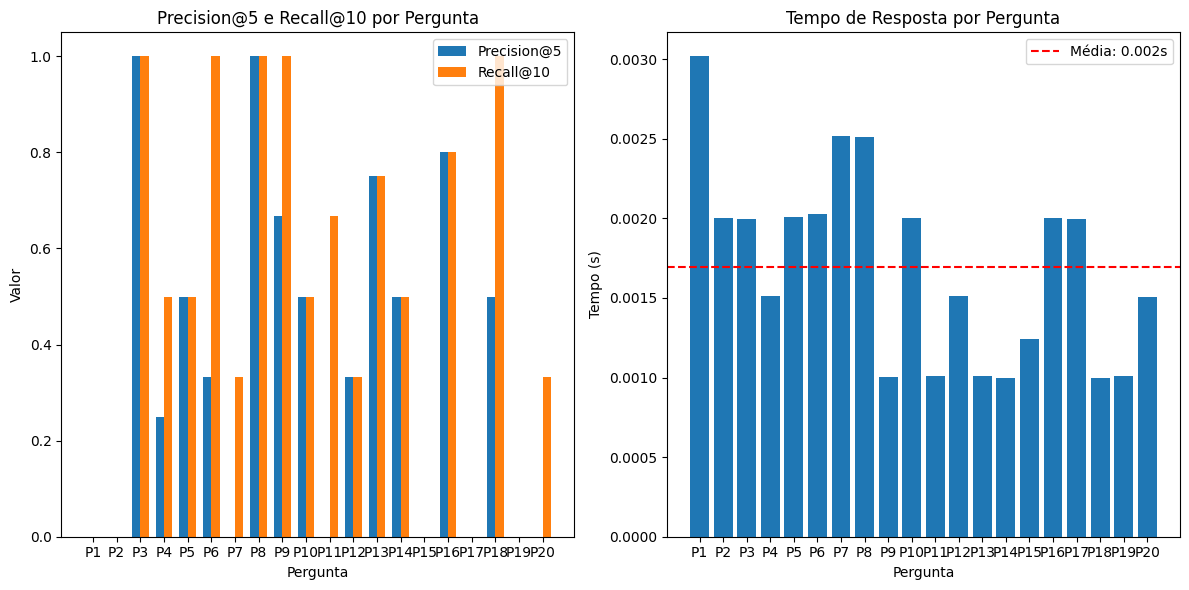

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# Gráfico de barras para Precision@5 e Recall@10
plt.subplot(1, 2, 1)
x = np.arange(len(perguntas_teste))
width = 0.35

plt.bar(x - width/2, precision_at_5_list, width, label='Precision@5')
plt.bar(x + width/2, recall_at_10_list, width, label='Recall@10')

plt.xlabel('Pergunta')
plt.ylabel('Valor')
plt.title('Precision@5 e Recall@10 por Pergunta')
plt.xticks(x, [f"P{i+1}" for i in range(len(perguntas_teste))])
plt.legend()

# Gráfico de tempo de resposta
plt.subplot(1, 2, 2)
plt.bar(x, tempos_resposta)
plt.axhline(y=media_tempo_resposta, color='r', linestyle='--', label=f'Média: {media_tempo_resposta:.3f}s')
plt.xlabel('Pergunta')
plt.ylabel('Tempo (s)')
plt.title('Tempo de Resposta por Pergunta')
plt.xticks(x, [f"P{i+1}" for i in range(len(perguntas_teste))])
plt.legend()

plt.tight_layout()
plt.show()


## 8. Salvar Resultados


In [30]:
# Salvar resultados em CSV
df_resultados.to_csv('../../data/metrics/resultados_avaliacao_otimizada_enriquecida_refinada.csv', index=False)

# Criar um resumo para relatório
resumo = {
    "versao": "otimizada_enriquecida_refinada",
    "modelo": "TF-IDF",
    "indexador": "sklearn",
    "enriquecimento": "entidades_nomeadas_e_tokens_otimizado",
    "precision_at_5": float(media_precision_at_5),
    "recall_at_10": float(media_recall_at_10),
    "f1_score": float(media_f1),
    "ndcg": float(media_ndcg),
    "mrr": float(media_mrr),
    "tempo_resposta_medio": float(media_tempo_resposta),
    "precision_at_k": [float(p) for p in precision_at_5_list],
    "recall_at_k": [float(r) for r in recall_at_10_list],
    "ndcg_at_k": [float(n) for n in ndcg_list],
    "mrr_values": [float(m) for m in mrr_list],
    "tempos_resposta": [float(t) for t in tempos_resposta]
}

import json
with open('../../data/metrics/metricas_versao_otimizada_enriquecida_refinada.json', 'w') as f:
    json.dump(resumo, f, indent=2)

# Análise por tipo de pergunta
perguntas_procedimentais = [
    'Qual o prazo para resposta do pedido de informação?',
    'Como recorrer de uma negativa de acesso à informação?',
    'Quais são os prazos de sigilo das informações?',
    'Como é feita a classificação de informações sigilosas?',
    'Como funciona o recurso em caso de negativa de acesso à informação?',
]

perguntas_conceituais = [
    'O que é a Lei de Acesso à Informação?',
    'Quais são os princípios da Lei de Acesso à Informação?',
    'Quais são as responsabilidades dos órgãos públicos em relação à LAI?',
    'Qual a diferença entre informação sigilosa e informação pessoal?',
    'Quais informações devem ser divulgadas proativamente pelos órgãos públicos?',
]

# Outras perguntas que não se encaixam claramente em uma das categorias
perguntas_mistas = [
    'Como solicitar informações públicas?',
    'Quais informações podem ser negadas?',
    'Quem pode solicitar informações públicas?',
    'Quais são as informações classificadas como sigilosas?',
    'Quais são as penalidades para quem não cumprir a LAI?',
    'Como a LAI protege informações pessoais?',
    'O que são informações sigilosas segundo a LAI?',
    'Quais são os direitos do cidadão garantidos pela LAI?',
    'Como é tratada a informação pessoal pela LAI?',
    'Como solicitar a desclassificação de uma informação sigilosa?'
]

# Criar uma coluna para categorizar as perguntas
df_resultados['categoria'] = 'Outra'
df_resultados.loc[df_resultados['pergunta'].isin(perguntas_procedimentais), 'categoria'] = 'Procedimental'
df_resultados.loc[df_resultados['pergunta'].isin(perguntas_conceituais), 'categoria'] = 'Conceitual'
df_resultados.loc[df_resultados['pergunta'].isin(perguntas_mistas), 'categoria'] = 'Mista'

# Análise estatística por categoria de pergunta
metricas_por_categoria = df_resultados.groupby('categoria').agg({
    'precision_at_5': ['mean', 'min', 'max'],
    'recall_at_10': ['mean', 'min', 'max'],
    'f1_score': ['mean', 'min', 'max'],
    'ndcg': ['mean', 'min', 'max'],
    'mrr': ['mean', 'min', 'max']
})

# Formatar o DataFrame para exibição
metricas_por_categoria = metricas_por_categoria.round(3)
print(metricas_por_categoria)

print("\n[✓] Resultados salvos em '../../data/metrics/resultados_avaliacao_otimizada_enriquecida_refinada.csv' e '../data/metrics/metricas_versao_otimizada_enriquecida_refinada.json'")


              precision_at_5             recall_at_10              f1_score  \
                        mean    min  max         mean   min    max     mean   
categoria                                                                     
Conceitual             0.000  0.000  0.0        0.133  0.00  0.667    0.000   
Mista                  0.292  0.000  0.5        0.500  0.00  1.000    0.333   
Procedimental          0.843  0.667  1.0        0.910  0.75  1.000    0.870   

                             ndcg                  mrr                
                min    max   mean    min    max   mean    min    max  
categoria                                                             
Conceitual     0.00  0.000  0.063  0.000  0.315  0.033  0.000  0.167  
Mista          0.00  0.667  0.294  0.000  0.599  0.272  0.000  0.500  
Procedimental  0.75  1.000  0.714  0.578  0.885  0.667  0.333  1.000  

[✓] Resultados salvos em '../../data/metrics/resultados_avaliacao_otimizada_enriquecida_refinada.c

## 9. Comparação com a Versão Completa


In [31]:
# Tentar carregar os resultados da versão completa (se disponíveis)
try:
    with open('../data/metrics/metricas_versao_completa_enriquecida_otimizada.json', 'r') as f:
        metricas_completa = json.load(f)
    
    # Criar dataframe de comparação
    comparacao = pd.DataFrame({
        'Métrica': ['Precision@5', 'Recall@10', 'F1-Score', 'Tempo Resposta (s)'],
        'Versão Otimizada (TF-IDF)': [
            f"{media_precision_at_5:.3f}",
            f"{media_recall_at_10:.3f}",
            f"{media_f1:.3f}",
            f"{media_tempo_resposta:.3f}"
        ],
        'Versão Completa (BERT)': [
            f"{metricas_completa['precision_at_5']:.3f}",
            f"{metricas_completa['recall_at_10']:.3f}",
            f"{metricas_completa['f1_score']:.3f}",
            f"{metricas_completa['tempo_resposta_medio']:.3f}"
        ]
    })
    
    print("=== COMPARAÇÃO ENTRE VERSÕES ===")
    print(comparacao)
    
    # Visualizar comparação
    plt.figure(figsize=(10, 6))
    
    # Dados para o gráfico
    metricas = ['Precision@5', 'Recall@10', 'F1-Score']
    otimizada = [media_precision_at_5, media_recall_at_10, media_f1]
    completa = [metricas_completa['precision_at_5'], 
                metricas_completa['recall_at_10'], 
                metricas_completa['f1_score']]
    
    x = np.arange(len(metricas))
    width = 0.35
    
    plt.bar(x - width/2, otimizada, width, label='Otimizada (TF-IDF)')
    plt.bar(x + width/2, completa, width, label='Completa (BERT)')
    
    plt.xlabel('Métrica')
    plt.ylabel('Valor')
    plt.title('Comparação de Desempenho entre Versões')
    plt.xticks(x, metricas)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Comparação de tempo de resposta
    plt.figure(figsize=(8, 5))
    plt.bar(['Otimizada (TF-IDF)', 'Completa (BERT)'], 
            [media_tempo_resposta, metricas_completa['tempo_resposta_medio']])
    plt.ylabel('Tempo (s)')
    plt.title('Tempo Médio de Resposta')
    plt.tight_layout()
    plt.show()
    
except FileNotFoundError:
    print("[!] Arquivo de métricas da versão completa não encontrado.")
    print("[!] Execute o notebook 'avaliacao_completa.ipynb' primeiro para comparar as versões.")
    
# Salvar resultados comparativos
df_resultados.to_csv('../../data/metrics/resultados_comparativos.csv', index=False)


[!] Arquivo de métricas da versão completa não encontrado.
[!] Execute o notebook 'avaliacao_completa.ipynb' primeiro para comparar as versões.
